In [1]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import folium
from folium import plugins
import json

warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (16,8)
plt.rc('font',family='Batang')

geo_path = 'data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

# 서울특별시 공공자전거 데이터  
서울특별시 공공자전거 대여소 정보
- http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do

서울특별시 공공자전거 대여이력 정보  
- http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

## 1. 대여소 분포

In [2]:
stop = pd.read_csv('C:/Users/keogu/Desktop/1번/data/공공자전거 대여소 정보_2021.01.31.csv')
stop.head()

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,LCD,QR,운영방식
0,301,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130,37.575794,126.971451,2015-10-07,16.0,NaN,LCD
1,302,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130,37.575947,126.974060,2015-10-07,12.0,NaN,LCD
2,303,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189,37.571770,126.974663,2015-10-07,8.0,NaN,LCD
3,304,광화문역 2번출구 앞,종로구,서울특별시 종로구 세종대로 지하172,37.572113,126.977577,2021-01-26,NaN,7.0,QR
4,305,종로구청 옆,종로구,서울특별시 종로구 삼봉로 43,37.572582,126.978355,2015-10-07,16.0,NaN,LCD


In [3]:
stop = stop.fillna(0)
stop['거치대수'] = stop['LCD'] + stop["QR"]
stop.drop(['LCD','QR','운영방식'],axis=1,inplace=True)
stop.head()

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,거치대수
0,301,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130,37.575794,126.971451,2015-10-07,16.0
1,302,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130,37.575947,126.974060,2015-10-07,12.0
2,303,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189,37.571770,126.974663,2015-10-07,8.0
3,304,광화문역 2번출구 앞,종로구,서울특별시 종로구 세종대로 지하172,37.572113,126.977577,2021-01-26,7.0
4,305,종로구청 옆,종로구,서울특별시 종로구 삼봉로 43,37.572582,126.978355,2015-10-07,16.0


### 1.1 점분포

In [5]:
stop_map = folium.Map(location=[stop['위도'].mean(), stop['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
for i, row in stop.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        fill=True,
    ).add_to(stop_map)
stop_map

In [10]:
stop_map.save("station.html")

### 1.2 히트맵 분포

In [12]:
stop_map2 = folium.Map(location=[stop['위도'].mean(), stop['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(stop[['위도', '경도']].values.tolist(),
                        radius=10, blur=5
                        ).add_to(stop_map2)
plugins.Fullscreen(positions='topright').add_to(stop_map2)
stop_map2

In [55]:
stop_map2.save('station2.html')

### 1.3 지역구별 대여소 개수

In [14]:
city_stop = stop.groupby('자치구').size()
city_stop = city_stop.sort_values(ascending=True, inplace=False)

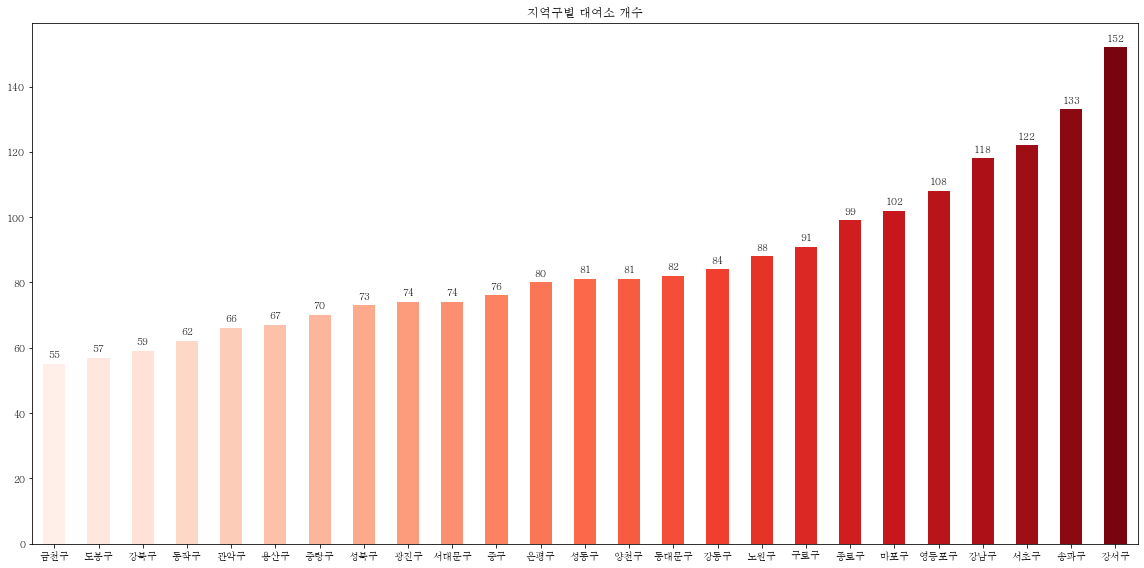

In [23]:
colors = sns.color_palette("Reds",len(city_stop))
ax = city_stop.plot(kind='bar',color=colors,rot=0, title="지역구별 대여소 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(True)
plt.xlabel('')
plt.tight_layout()
plt.savefig('지역구별 대여소 개수.jpg')
plt.show()

In [24]:
city_stop_map = folium.Map(location=[stop['위도'].mean(), stop['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=city_stop,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Reds').add_to(city_stop_map)
city_stop_map

In [54]:
city_stop_map.save('station3.html')

### 시각화 결과  
**강서구, 송파구, 서초구 순으로 가장 많은 대여소가 설치되어 있고 금천구가 56개의 대여소로 가장 적게 설치되어 있다.**

## 2. 거치대 분포  
- 현재는 안 쓸 예정

have_bike = stop.groupby('자치구')['거치대수'].sum()
have_bike = have_bike.sort_values(ascending=False, inplace=False)
have_bike_top10 = have_bike[:10]

ax = have_bike_top10.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

have_bike_map = folium.Map(location=[stop['위도'].mean(), stop['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=have_bike,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(have_bike_map)
have_bike_map

## 3. 공공자전거 사용량

In [26]:
rental01 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.01.csv',encoding='cp949')
rental02 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.02.csv',encoding='cp949')
rental03 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.03.csv',encoding='cp949')
rental04 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.04.csv',encoding='cp949')
rental05 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.05.csv',encoding='cp949')
rental06 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.06.csv',encoding='cp949')
rental078 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.07_08.csv',encoding='cp949')
rental09 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.09.csv',encoding='cp949')
rental010 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.10.csv',encoding='cp949')
rental011 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.11.csv',encoding='cp949')
rental012 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2020.12.csv',encoding='cp949')
rental11 = pd.read_csv('data/공공자전거 대여이력 정보/공공자전거 대여이력 정보_2021.01.csv',encoding='cp949')

In [27]:
allData = [rental01,rental02,rental03,rental04,rental05,rental06,rental078,rental09,rental010,rental011,rental012]

In [28]:
rental = pd.concat(allData, axis=0, ignore_index=True)

In [29]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18570545 entries, 0 to 18570544
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   자전거번호     object 
 1   대여일시      object 
 2   대여 대여소번호  int64  
 3   대여 대여소명   object 
 4   대여거치대     object 
 5   반납일시      object 
 6   반납대여소번호   object 
 7   반납대여소명    object 
 8   반납거치대     int64  
 9   이용시간      float64
 10  이용거리      float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.5+ GB


In [30]:
rental.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-04061,2020-01-01 00:01:04,429,송도병원,2,2020-01-01 00:04:21,00372,약수역 3번출구 뒤,8,2.0,0.0
1,SPB-06686,2020-01-01 00:02:53,1637,KT 노원점 건물 앞,14,2020-01-01 00:04:48,01656,중앙하이츠 아파트 입구,9,1.0,350.0
2,SPB-15937,2020-01-01 00:01:21,1924,삼부르네상스파크빌,10,2020-01-01 00:05:51,01955,디지털입구 교차로,7,4.0,800.0
3,SPB-14805,2020-01-01 00:03:12,437,대흥역 1번출구,1,2020-01-01 00:05:54,00126,서강대 후문 옆,18,2.0,0.0
4,SPB-09038,2020-01-01 00:01:11,1168,마곡엠밸리10단지 앞,5,2020-01-01 00:05:57,01152,마곡역교차로,2,4.0,660.0


In [31]:
rental.rename(columns={"대여 대여소번호":"대여소번호"},inplace=True)

In [32]:
rental = pd.merge(rental, stop[['자치구', '대여소번호']], on='대여소번호')
rental.rename(columns={
    "대여소번호": "대여 대여소 번호",
    "자치구": "대여 지역"
}, inplace=True)
rental.head()

,자전거번호,대여일시,대여 대여소 번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,대여 지역
0,SPB-04061,2020-01-01 00:01:04,429,송도병원,2,2020-01-01 00:04:21,00372,약수역 3번출구 뒤,8,2.0,0.0,중구
1,SPB-25060,2020-01-01 04:01:28,429,송도병원,1,2020-01-01 04:15:14,00568,청계8가사거리 부근,5,13.0,2740.0,중구
2,SPB-23668,2020-01-01 16:50:06,429,송도병원,5,2020-01-01 17:54:28,02302,교보타워 버스정류장(신논현역 3번출구 후면),4,62.0,32500.0,중구
3,SPB-05788,2020-01-01 16:50:14,429,송도병원,7,2020-01-01 17:54:47,02302,교보타워 버스정류장(신논현역 3번출구 후면),5,64.0,6840.0,중구
4,SPB-11918,2020-01-01 17:59:15,429,송도병원,6,2020-01-01 18:08:58,00429,송도병원,6,9.0,0.0,중구


In [33]:
rental = pd.merge(rental, stop[['자치구', '대여소번호']], left_on='반납대여소번호', right_on='대여소번호').drop(columns='대여소번호')
rental.rename(columns={
    "자치구": "반납 지역"
}, inplace=True)

rental.head()

,자전거번호,대여일시,대여 대여소 번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,대여 지역,반납 지역
0,SPB-03413,2020-01-06 16:15:37,429,송도병원,1,2020-01-06 16:46:59,612,시립동부병원 앞 사거리,3,31.0,4720.0,중구,동대문구
1,SPB-03791,2020-01-08 17:13:58,429,송도병원,5,2020-01-08 17:40:15,612,시립동부병원 앞 사거리,1,25.0,4620.0,중구,동대문구
2,SPB-06812,2020-01-09 17:30:15,429,송도병원,5,2020-01-09 18:01:02,612,시립동부병원 앞 사거리,3,30.0,5000.0,중구,동대문구
3,SPB-15155,2020-01-22 16:16:15,429,송도병원,3,2020-01-22 16:47:04,612,시립동부병원 앞 사거리,2,30.0,0.0,중구,동대문구
4,SPB-11995,2020-01-23 17:11:39,429,송도병원,4,2020-01-23 17:38:51,612,시립동부병원 앞 사거리,2,26.0,4040.0,중구,동대문구


### 3.1 지역구별 대여량

In [34]:
rental_bike = rental.groupby('대여 지역').size()
rental_bike = rental_bike.sort_values(ascending=True, inplace=False)

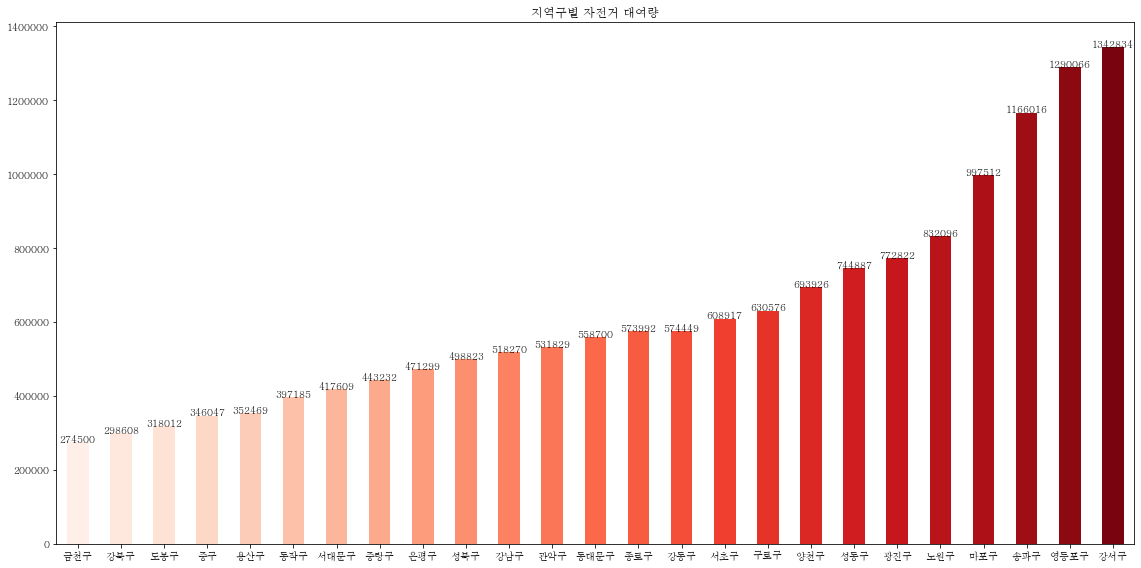

In [35]:
colors = sns.color_palette("Reds",len(rental_bike))
ax = rental_bike.plot(kind='bar', color=colors, rot=0, title="지역구별 자전거 대여량")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(True)
plt.xlabel('')
plt.tight_layout()
plt.savefig('지역구별 자전거 대여량')
plt.show()

### 3.2 지역구별 반납량

In [36]:
return_bike = rental.groupby('반납 지역').size()
return_bike = return_bike.sort_values(ascending=True, inplace=False)

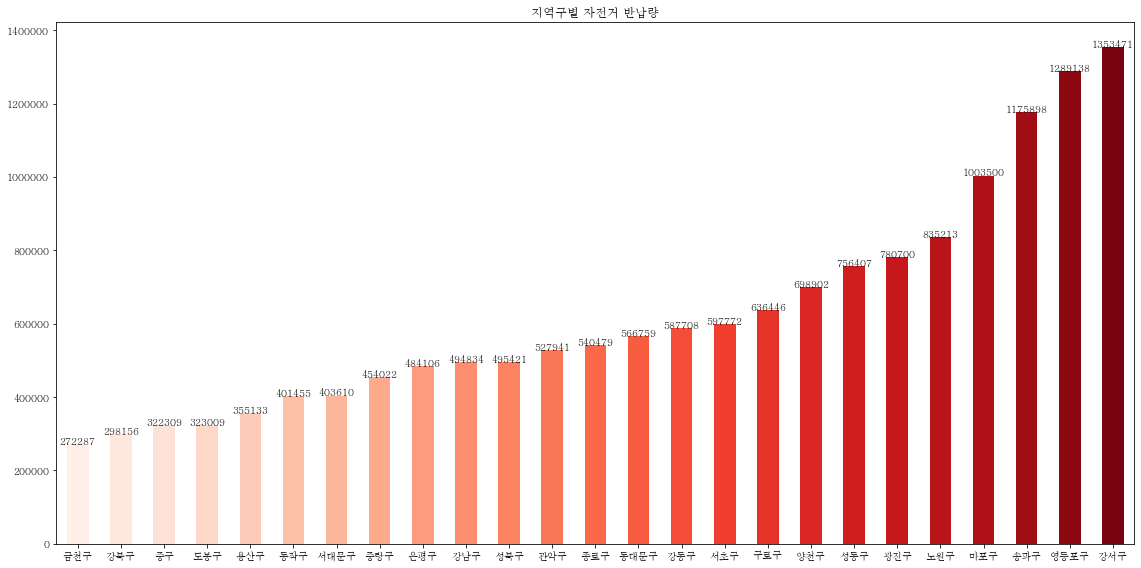

In [37]:
colors = sns.color_palette("Reds",len(return_bike))
ax = return_bike.plot(kind='bar',color=colors, rot=0, title="지역구별 자전거 반납량")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(True)
plt.xlabel('')
plt.tight_layout()
plt.savefig('지역구별 자전거 반납량')
plt.show()

### 시각화 결과
**대여량과 반납량이 서로 비슷한 결과를 나타내고 있으며, 강서구,영등포구,송파구 순으로 높은 사용량을 기록하고 있다. 금천구가 가장 적은 사용량을 나타내고 있다**

### 3.3 일별 대여량

In [38]:
rental['대여일시'] = pd.to_datetime(rental['대여일시'],format='%Y-%m-%d %H:%M:%S')

In [39]:
rental['년'] = rental['대여일시'].dt.year
rental['월'] = rental['대여일시'].dt.month
rental['일'] = rental['대여일시'].dt.day
rental['요일'] = rental['대여일시'].dt.day_name()

In [40]:
rental.head()

,자전거번호,대여일시,대여 대여소 번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,대여 지역,반납 지역,년,월,일,요일
0,SPB-03413,2020-01-06 16:15:37,429,송도병원,1,2020-01-06 16:46:59,612,시립동부병원 앞 사거리,3,31.0,4720.0,중구,동대문구,2020,1,6,Monday
1,SPB-03791,2020-01-08 17:13:58,429,송도병원,5,2020-01-08 17:40:15,612,시립동부병원 앞 사거리,1,25.0,4620.0,중구,동대문구,2020,1,8,Wednesday
2,SPB-06812,2020-01-09 17:30:15,429,송도병원,5,2020-01-09 18:01:02,612,시립동부병원 앞 사거리,3,30.0,5000.0,중구,동대문구,2020,1,9,Thursday
3,SPB-15155,2020-01-22 16:16:15,429,송도병원,3,2020-01-22 16:47:04,612,시립동부병원 앞 사거리,2,30.0,0.0,중구,동대문구,2020,1,22,Wednesday
4,SPB-11995,2020-01-23 17:11:39,429,송도병원,4,2020-01-23 17:38:51,612,시립동부병원 앞 사거리,2,26.0,4040.0,중구,동대문구,2020,1,23,Thursday


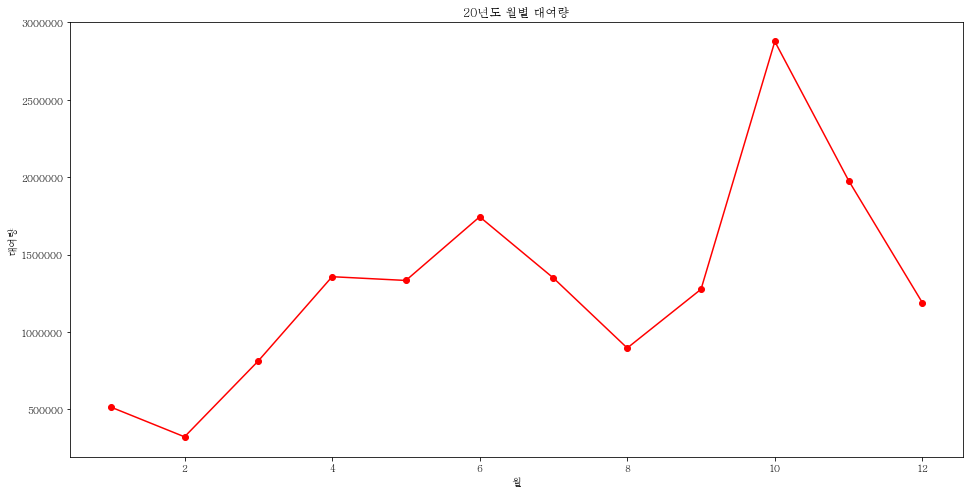

In [41]:
month = [1,2,3,4,5,6,7,8,9,10,11,12]
rental_month=rental.groupby('월').size()
plt.plot(month,rental_month,color='red',marker='o')
plt.xlabel('월')
plt.ylabel('대여량')
plt.title("20년도 월별 대여량")
plt.show()

## 4. 대여소 수 선정

### 4.1 대여소 수/인구 수

#### 구별 인구수

In [42]:
df = pd.read_excel('C:/Users/keogu/Desktop/1번/report.xls')

In [43]:
df.drop(index=[0,1,2],inplace=True)

In [44]:
people = df[['자치구','인구']]

In [45]:
stop = city_stop.to_frame(name='대여소')

In [46]:
stop = stop.reset_index()

In [47]:
station = pd.merge(people,stop,on='자치구')

In [48]:
station['대여소/인구'] = station['대여소']/station['인구']

In [49]:
station

,자치구,인구,대여소,대여소/인구
0,종로구,155106,99,0.000638
1,중구,132259,76,0.000575
2,용산구,240665,67,0.000278
3,성동구,295767,81,0.000274
4,광진구,355306,74,0.000208
5,동대문구,352259,82,0.000233
6,중랑구,394679,70,0.000177
7,성북구,443206,73,0.000165
8,강북구,306093,59,0.000193
9,도봉구,322419,57,0.000177


In [53]:
station.to_csv('station.csv',encoding='cp949')

In [50]:
station.mean()

인구        391817.040000
대여소           86.160000
대여소/인구         0.000243
dtype: float64

### 결과
**서울시 구별로 인구와 대여소 수를 구해본 결과 다음과 같다**  
**인천시 미추홀구의 도입되는 적정한 대여소 수를 찾기 위해 서울시 대여소 수/인구 수의 비율을 구함**  
**구한 평균 비율인 0.000243을 인천시 미추홀구 인구 수와 곱해서 적정한 대여소 수를 찾는다**